# Calculating a Company's Probability of Default with Python

**Hugh Donnelly, CFA**<br> 
*AlphaWave Data*

**March 2021**

For this analysis, we use several Python-based scientific computing technologies along with the [AlphaWave Data Stock Analysis API](https://rapidapi.com/alphawave/api/stock-analysis/endpoints).  Jupyter Notebooks detailing this analysis are also available on [Google Colab](https://colab.research.google.com/drive/1GbxEJ1JuZUEviLCpRU7b73engWZzYYzh?usp=sharing) and [Github](https://github.com/AlphaWaveData/Jupyter-Notebooks/blob/master/AlphaWave%20Market-Implied%20Probability%20of%20Default%20Example.ipynb).

In [1]:
import time
import requests
import selenium
import numpy as np
import pandas as pd
from sympy import *
from datetime import date
from datetime import timedelta
from selenium import webdriver
import pandas_datareader as dr
import matplotlib.pyplot as plt
from datetime import datetime as dt
from bs4 import BeautifulSoup as bs
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

We will use SM Energy (SM) in the subsequent code; however, this analysis works with the ticker of any large publicly traded company.

In [2]:
# Required
company_ticker = 'SM'

# Optional
company_name = 'SM Energy'

# Optional Input Choices:
# ALL, Annual, Anytime, Bi-Monthly, Monthly, N/A, None, Pays At Maturity, Quarterly, Semi-Annual, Variable
coupon_frequency = 'Semi-Annual'

### Introduction to Probability of Default

The probability of default is the probability that a bond issuer will not meet its contractual obligations on schedule. Although the most common event of default is nonpayment leading to bankruptcy proceedings, the bond prospectus might identify other events of default, such as the failure to meet a different obligation or the violation of a financial covenant.

In the following example, we will determine the probability of default given corporate bond prices. The default probabilities that are reached in this exercise are called market-implied default probabilities. Historically, practitioners have focused on the one-year probability of default calculation. We know that over shorter horizons of one or two years firms are exposed to the credit cycle effect, while over longer horizons, the business cycle effect tends to have a lesser impact and the company’s capital structure becomes more important. This effect has made long-run risk levels less cyclical and more stable. Intuitively, default risk over a longer time period is less sensitive to the instantaneous default rates in the economy.  For this reason, we will focus on corporate bonds with one or two years until maturity to calculate the market-implied default probabilities.

We will verify the accuracy of the market-implied default probabilities with the Standard & Poor’s Average One-Year Transition Rates For Global Corporates using historical data from 1981-2019.  This transition matrix shows the observed historical probabilities of a particular rating transitioning to another rating, including default, over the course of one year.

In order to calculate the market-implied default probabilities, we must first acquire the company's current bond prices. Using a short Selenium script that emulates a user's keystrokes and clicks in a browser as a means of navigating to FINRA's TRACE bond data, we can access the data needed to calculate the market-implied default probabilities.

The following is an example script. In case you do not have [Selenium](https://pypi.org/project/selenium/) installed, you can visit their respective links and download them using pip in your terminal. We will also need a chromedriver (the simulated chrome browser Selenium controls) and to download it using Python you can use the [webdriver-manager](https://pypi.org/project/webdriver-manager/) package also found in PyPi.

You will need to insert your own path to your chromedriver in the code block below.

In [3]:
# Selenium script
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
driver = webdriver.Chrome(options=chrome_options, executable_path=r'/PATH/TO/YOUR/chromedriver')

# store starting time
begin = time.time()

# FINRA's TRACE Bond Center
driver.get('http://finra-markets.morningstar.com/BondCenter/Results.jsp')

# click agree
WebDriverWait(driver, 10).until(EC.element_to_be_clickable(
    (By.CSS_SELECTOR, ".button_blue.agree"))).click()

# click edit search
WebDriverWait(driver, 10).until(EC.element_to_be_clickable(
    (By.CSS_SELECTOR, 'a.qs-ui-btn.blue'))).click()

# input Issuer Name
WebDriverWait(driver, 10).until(EC.presence_of_element_located(
    (By.CSS_SELECTOR, 'input[id=firscreener-issuer]')))
inputElement = driver.find_element_by_id("firscreener-issuer")
inputElement.send_keys(company_name)

# input Symbol
WebDriverWait(driver, 10).until(EC.presence_of_element_located(
    (By.CSS_SELECTOR, 'input[id=firscreener-cusip]')))
inputElement = driver.find_element_by_id("firscreener-cusip")
inputElement.send_keys(company_ticker)

# click advanced search
WebDriverWait(driver, 10).until(EC.element_to_be_clickable(
    (By.CSS_SELECTOR, 'a.ms-display-switcher.hide'))).click()

# input Coupon Frequency
WebDriverWait(driver, 10).until(EC.presence_of_element_located(
    (By.CSS_SELECTOR, 'select[name=interestFrequency]')))
Select((driver.find_elements_by_css_selector(
    'select[name=interestFrequency]'))[0]).select_by_visible_text(coupon_frequency)

# click show results
WebDriverWait(driver, 10).until(EC.element_to_be_clickable(
    (By.CSS_SELECTOR, 'input.button_blue[type=submit]'))).click()

# wait for results
WebDriverWait(driver, 10).until(EC.presence_of_element_located(
    (By.CSS_SELECTOR, '.rtq-grid-row.rtq-grid-rzrow .rtq-grid-cell-ctn')))

# create dataframe from scrape
frames = []
for page in range(1, 11):
    bonds = []
    WebDriverWait(driver, 10).until(EC.presence_of_element_located(
        (By.CSS_SELECTOR, (f"a.qs-pageutil-btn[value='{str(page)}']"))))  # wait for page marker to be on expected page
    time.sleep(2)

    headers = [title.text for title in driver.find_elements_by_css_selector(
    '.rtq-grid-row.rtq-grid-rzrow .rtq-grid-cell-ctn')[1:]]

    tablerows = driver.find_elements_by_css_selector(
        'div.rtq-grid-bd > div.rtq-grid-row')
    for tablerow in tablerows:
        tablerowdata = tablerow.find_elements_by_css_selector(
            'div.rtq-grid-cell')
        bond = [item.text for item in tablerowdata[1:]]
        bonds.append(bond)

        # Convert to Dataframe
        df = pd.DataFrame(bonds, columns=headers)

    frames.append(df)

    try:
        driver.find_element_by_css_selector('a.qs-pageutil-next').click()
    except:
        break

bond_prices_df = pd.concat(frames)

# store end time 
end = time.time()

# total time taken 
print(f"Total runtime of the program is {end - begin} seconds")

bond_prices_df

Total runtime of the program is 6.986101150512695 seconds


,Issuer Name,Symbol,Callable,Sub-Product Type,Coupon,Maturity,Moody's®,S&P,Price,Yield
0,SM ENERGY CO,SM4141342,Yes,Corporate Bond,5.000,01/15/2024,Caa2,B-,97.100,6.116
1,SM ENERGY CO,SM4243713,Yes,Corporate Bond,5.625,06/01/2025,Caa2,B-,95.250,6.933
2,SM ENERGY CO,SM4269795,Yes,Corporate Bond,6.125,11/15/2022,Caa2,B-,100.025,6.102
3,SM ENERGY CO,SM4392432,,Corporate Bond,1.500,07/01/2021,,,98.400,5.667
4,SM ENERGY CO,SM4401573,Yes,Corporate Bond,6.750,09/15/2026,Caa2,B-,95.500,7.765
5,SM ENERGY CO,SM4664064,Yes,Corporate Bond,6.625,01/15/2027,Caa2,B-,95.020,7.694
6,SM ENERGY CO,SM5003694,Yes,Corporate Bond,10.000,01/15/2025,B3,B,113.269,4.941


We will now filter the corporate bond prices dataframe to align with the purpose of this example using the code below.

In [4]:
def bond_dataframe_filter(df):
# Drop bonds with missing yields and missing credit ratings
    df['Yield'].replace('', np.nan, inplace=True)
    df["Moody's®"].replace({'WR':np.nan,'':np.nan}, inplace=True)
    df["S&P"].replace({'NR':np.nan,'':np.nan}, inplace=True)
    df = df.dropna(subset=['Yield'])
    df = df.dropna(subset=["Moody's®"])
    df = df.dropna(subset=["S&P"])

# Create Maturity Years column that aligns with Semi-Annual Payments from corporate bonds
    df['Yield'] = df['Yield'].astype(float)
    df['Coupon'] = df['Coupon'].astype(float)
    df['Price'] = df['Price'].astype(float)
    now = dt.strptime(date.today().strftime('%m/%d/%Y'), '%m/%d/%Y')
    df['Maturity'] = pd.to_datetime(df['Maturity']).dt.strftime('%m/%d/%Y')
    daystillmaturity = []
    yearstillmaturity = []
    for maturity in df['Maturity']:
        daystillmaturity.append(
            (dt.strptime(maturity, '%m/%d/%Y') - now).days)
        yearstillmaturity.append(
            (dt.strptime(maturity, '%m/%d/%Y') - now).days/360)
    df = df.reset_index(drop=True)
    df['Maturity'] = pd.Series(daystillmaturity)
#         df['Maturity Years'] = pd.Series(yearstillmaturity).round() # Better for Annual Payments
    df['Maturity Years'] = round(pd.Series(yearstillmaturity)/0.5)*0.5 # Better for Semi-Annual Payments

# Target bonds with short-term maturities 
    df['Maturity'] = df['Maturity'].astype(float)
    df = df.loc[df['Maturity'] >= 0]
    years_mask = (df['Maturity Years'] > 0) & (df['Maturity Years'] <= 2)
    df = df.loc[years_mask]
    return df

In [5]:
bond_df_result = bond_dataframe_filter(bond_prices_df)
bond_df_result

,Issuer Name,Symbol,Callable,Sub-Product Type,Coupon,Maturity,Moody's®,S&P,Price,Yield,Maturity Years
2,SM ENERGY CO,SM4269795,Yes,Corporate Bond,6.125,622.0,Caa2,B-,100.025,6.102,1.5


### 1. Market-Implied Probability of Default

To calculate the probability of default using current corporate bond prices, we will use bond valuation techniques. The valuation of corporate bonds is similar to that of any risky asset; it is dependent on the present value of future expected cash flows, discounted at a risk-adjusted rate (similar to Discounted Cash Flow analysis).

\begin{equation*}
BOND\ PRICE = \frac{ECF_1}{1+d}\ +\ \frac{ECF_2}{(1+d)^2}\ +\ \frac{ECF_3}{(1+d)^3}
\end{equation*}

$ECF = Expected\ Cash\ Flow$<br>
$d = Risk-adjusted\ Discount\ Rate$<br>

Corporate bond valuation also accounts for the probability of the bond defaulting and not paying back the principal in full.

**1a. Estimating the Expected Cash Flows**<br>
The first step in valuing the bond is to find the Expected Cash Flow at each period. This is done by adding the product of the Default Payout and the Probability of Default (P) with the product of the promised payment (Coupon Payments and repayment of Principal) and the probability of not defaulting (1-P), which is also referred to as the probability of survival.

$ECF_1 = (P)*(Default\ Payout)\ +\ (1-P)*(Coupon\ Payment)$<br>
$ECF_2 = (1-P)*\{(P)\ *(Default\ Payout)\ +\ (1-P)*(Coupon\ Payment)\}$<br>
$ECF_3 = (1-P)^2*\{(P)\ *(Default\ Payout)\ +\ (1-P)*(Coupon\ Payment\ +\ Principal)\}$<br>

$P = Probability\ of\ Default$<br>
$Default\ Payout = Principal\ *\ Recovery\ Rate$<br>

The Default Payout is calculated as the product of the Recovery Rate and the Principal if the bond defaults. In the following example, the Principal will be at par value for the bond (e.g. $100). The Recovery Rate is the percentage of the loss recovered from a bond in default. The Recovery Rate varies by industry, the degree of seniority in the capital structure, the amount of leverage in the capital structure in total, and whether a particular security is secured or otherwise collateralized. We assume a 40% Recovery Rate for the corporate bonds in the following example, which is a common baseline assumption in practice.

The code in the below function shows how the Expected Cash Flow is calculated at each period.  We then use the solve function from the Python library *sympy* to calculate the Probability of Default that will equate future Expected Cash Flows with the current price of the corporate bond when discounted at the risk-adjusted rate.  Running the cell below defines the function for use, but it will not run the function.  We will wait to run the function until after the Risk-adjusted Discount Rate is calculated.

In [6]:
def bonds_probability_of_default(coupon, maturity_years, bond_price, principal_payment, risk_adjusted_discount_rate):
    
    price = bond_price
    prob_default_exp = 0
    
#     times = np.arange(1, maturity_years+1) # For Annual Cashflows
#     annual_coupon = coupon # For Annual Cashflows
    times = np.arange(0.5, (maturity_years-0.5)+1,0.5) # For Semi-Annual Cashflows
    semi_annual_coupon = coupon/2 # For Semi-Annual Cashflows
    
    # Calculation of Expected Cash Flow
    cashflows = np.array([])
    for i in times[:-1]:
#         cashflows = np.append(cashflows, annual_coupon) # For Annual Cashflows
#     cashflows = np.append(cashflows, annual_coupon+principal_payment)#  For Annual Cashflows
        cashflows = np.append(cashflows, semi_annual_coupon) # For Semi-Annual Cashflows
    cashflows = np.append(cashflows, semi_annual_coupon+principal_payment) # For Semi-Annual Cashflows
    
    for i in range(len(times)):
#         This code block is used if there is only one payment remaining
        if len(times) == 1:
            prob_default_exp += ((cashflows[i]*(1-P) + cashflows[i]*recovery_rate*P) / \
                                np.power((1 + risk_adjusted_discount_rate), times[i]))
#         This code block is used if there are multiple payments remaining
        else:
#             For Annual Cashflows
#             if times[i] == 1:
#                 prob_default_exp += ((cashflows[i]*(1-P) + principal_payment*recovery_rate*P) / \
#                                     np.power((1 + risk_adjusted_discount_rate), times[i]))
#             For Semi-Annual Cashflows
            if times[i] == 0.5:
                prob_default_exp += ((cashflows[i]*(1-P) + principal_payment*recovery_rate*P) / \
                                    np.power((1 + risk_adjusted_discount_rate), times[i]))
#             Used for either Annual or Semi-Annual Cashflows
            else:
                prob_default_exp += (np.power((1-P), times[i-1])*(cashflows[i]*(1-P) + principal_payment*recovery_rate*P)) / \
                                    np.power((1 + risk_adjusted_discount_rate), times[i])


    prob_default_exp = prob_default_exp - price    
    implied_prob_default = solve(prob_default_exp, P)
    implied_prob_default = round(float(implied_prob_default[0]) * 100, 2)
    
    if implied_prob_default < 0:
        return 0.0
    else:
        return implied_prob_default

**1b. Estimating the Risk-Adjusted Discount Rate**<br>
After the Expected Cash Flows are calculated, they are discounted back to period 0 at a Risk-adjusted Discount Rate (d) to calculate the bond’s price. A Risk-adjusted Discount Rate is the rate obtained by combining an Expected Risk Premium with the Risk-free Rate during the calculation of the present value of a risky investment.

\begin{equation*}
Risk-adjusted\ Discount\ Rate\ =\ Risk-free\ Interest\ Rate\ +\ Expected\ Risk\ Premium
\end{equation*}

We use the Risk-adjusted Discount Rate in order to account for the liquidity, maturity, and tax considerations that cause corporate bonds to have an observed spread over the yield on a risk-free bond like government bonds. The minimum required return expected for a bond investor is equal to the sum of the following, which accounts for this spread between corporate bonds and risk-free bonds:

* **Default Risk Premium** – Compensates investors for the business’ likelihood of default.
* **Liquidity Premium** – Compensates investors for investing in less liquid securities such as bonds. Government bonds typically are more liquid than corporate bonds. Government bonds are available in greater supply than even the most liquid corporates and have demand from a wider set of institutional investors. In addition, government bonds can be used more readily as collateral in repo transactions and for centrally cleared derivatives.
* **Maturity Premium** – Compensates investors for the risk associated with bonds that mature many years into the future, which inherently carry more risk.
* **Taxation Premium** – Compensates investors for the taxable income that bonds generate. Interest income on US corporate bonds is taxable by both the federal and state governments. Government debt, however, is exempt from taxes at the state level.
* **Projected Inflation** – Accounts for the devaluation of currency over time.
* **Risk-free Rate** – Refers to the rate of return an investor can expect on a riskless security (such as a T-bill).

We begin our calculation of the Risk-adjusted Discount Rate by first turning our attention to estimating the Expected Risk Premium.

*Estimating the Expected Risk Premium*<br>
The Expected Risk Premium is obtained by subtracting the Risk-free Rate of Return from the Market Rate of Return and then multiplying the result by the Beta that adjusts based on the magnitude of the investment risk involved. By carefully selecting a proxy short-term corporate bond's Beta to the overall market, we can calculate an Expected Risk Premium that will result in a Risk-adjusted Discount Rate that incorporates liquidity, maturity, and tax considerations to produce a more accurate Probability of Default when using the bond valuation technique.

\begin{equation*}
Expected\ Risk\ Premium\ =\ (Market\ Rate\ of\ Return\ \ \ -\ \ \ Risk-free\ Rate\ of\ Return)\ *\ Beta
\end{equation*}

To calculate the Expected Risk Premium, we must first calculate the Market Rate of Return.  We can use the Capital Asset Pricing Model (CAPM) to determine the Market Rate of Return.

$$r_m = r_f\ +(\beta*MRP)$$<br>
$r_m = Market\ Rate\ of\ Return$<br>
$r_f = Risk-free\ Rate$<br>
$\beta = Beta$<br>
$MRP = Market\ Risk\ Premium$<br>

CAPM is an equilibrium model that takes the Risk-free Rate, the stock market's Beta, and the Market Risk Premium as inputs.  Let's now determine the value for each of these inputs.

Government securities are assumed to be risk-free, at least from a credit standpoint.  With this assumption, the appropriate rate to use in the Market Rate of Return calculation is the government security having approximately the same duration as the asset being valued and sufficient liquidity so that the yield does not have an embedded liquidity risk premium.  Equities are assumed to have a long duration, so a long-term government bond yield is an appropriate proxy for the Risk-free Rate.

In this step, the yield on the 10 Year U.S. Treasury Note will be used as the Risk-free Rate.  We can scrape the current yield on the 10 Year U.S. Treasury Note from Yahoo Finance using the code below.

In [7]:
# Ten-Year Risk-free Rate
timespan = 100
current_date = date.today()
past_date = current_date-timedelta(days=timespan)
ten_year_risk_free_rate_df = dr.DataReader('^TNX', 'yahoo', past_date, current_date) 
ten_year_risk_free_rate = (ten_year_risk_free_rate_df.iloc[len(ten_year_risk_free_rate_df)-1,5])/100
ten_year_risk_free_rate

0.014859999418258668

The Market Risk Premium should be the expected return on the market index less the expected return (or yield) on the long-term government bond.  For our purposes, we use the annual [Market Risk Premium](http://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/ctryprem.html) provided by Aswath Damodaran, who is a professor at the Stern School of Business at New York University.  Professor Damodaran teaches Corporate Finance and Equity Instruments & Markets.  He provides a multitude of financial information and I encourage you to visit his [website](http://pages.stern.nyu.edu/~adamodar/).

In [28]:
# Market Risk Premium
market_risk_premium = 0.0472

According to asset pricing theory, Beta represents the type of risk, systematic risk, that cannot be diversified away. By definition, the market itself has a Beta of 1.  As a result, Beta will be equal to 1 when calculating the Market Rate of Return.

In [9]:
# Market Equity Beta
stock_market_beta = 1

We now have all the inputs required to calculate the Market Rate of Return.

In [29]:
# Market Rate of Return
market_rate_of_return = ten_year_risk_free_rate + (stock_market_beta*market_risk_premium)
market_rate_of_return

0.06205999941825867

Now that we have calculated the Market Rate of Return, we can determine the Expected Risk Premium by subtracting the Risk-free Rate from the Market Rate of Return and multiplying the result by the Beta for the bond.

\begin{equation*}
Expected\ Risk\ Premium\ =\ (Market\ Rate\ of\ Return\ \ \ -\ \ \ Risk-free\ Rate\ of\ Return)\ *\ Beta
\end{equation*}

In this step, we will use a one-year Risk-free Rate so that the Expected Risk Premium matches the duration we want for the Risk-adjusted Discount Rate.  We accomplish this by taking the yield on the very liquid 10 Year U.S. Treasury Note and raising it to the power of 1/10 in order to convert the yield to a one-year equivalent.

In [30]:
# One-Year Risk-free Rate
one_year_risk_free_rate = (1 + ten_year_risk_free_rate)**(1/10) - 1
one_year_risk_free_rate

0.0014761555839097884

The final component needed to calculate the Expected Risk Premium is the corporate bond's Beta.  Knowing that differences in liquidity within the universe of corporate bonds are great, we use the Vanguard Short-Term Corporate Bond Index Fund ETF Shares (VCSH) as a proxy for short-term maturity bonds.  The Beta from this Short-Term Corporate Bond Index will enable us to embed some of the liquidity and maturity risk into the Risk-adjusted Discount Rate that will be used to calculate the Probability of Default for the corporate bonds we will be analyzing.  This should allow for better isolation of the credit risk associated with the chosen bonds.

A bond's Beta is the sensitivity of that bond's return to the return of the market index.  It is a measure of systematic risk and can be obtained using the [Key Statistics](https://rapidapi.com/alphawave/api/stock-analysis?endpoint=apiendpoint_dff4b882-4be4-4169-a700-04275c92bdce) endpoint from the [AlphaWave Data Stock Analysis API](https://rapidapi.com/alphawave/api/stock-analysis/endpoints) using the code below. You will need to insert your own x-rapidapi-host and x-rapidapi-key information in the code blocks below.

In [12]:
# Vanguard Short-Term Corporate Bond Index Fund ETF Shares
bond_fund_ticker = 'VCSH'

In [14]:
url = "https://stock-analysis.p.rapidapi.com/api/v1/resources/key-stats"

querystring = {"ticker":bond_fund_ticker}

headers = {
    'x-rapidapi-host': "YOUR_X-RAPIDAPI-HOST_WILL_COPY_DIRECTLY_FROM_RAPIDAPI_PYTHON_CODE_SNIPPETS",
    'x-rapidapi-key': "YOUR_X-RAPIDAPI-KEY_WILL_COPY_DIRECTLY_FROM_RAPIDAPI_PYTHON_CODE_SNIPPETS"
    }

bond_fund_key_stats_response = requests.request("GET", url, headers=headers, params=querystring)

# Create Key Statistics DataFrame
bond_fund_key_stats_df = pd.DataFrame.from_dict(bond_fund_key_stats_response.json())
bond_fund_key_stats_df = bond_fund_key_stats_df.transpose()
bond_fund_key_stats_df

,Value
52-week range,71.19 - 83.50
Ask,82.65 x 1800
Avg. volume,3430085
Beta (5Y monthly),0.58
Bid,82.64 x 900
Day's range,82.60 - 82.68
Expense ratio (net),0.05%
Inception date,2009-11-19
NAV,82.65
Net assets,44.06B


In [15]:
# Bond's Beta
bond_beta = float(bond_fund_key_stats_df.loc[r'Beta (5Y monthly)'])
bond_beta

0.58

We now have all the components required to calculate the Expected Risk Premium.

In [31]:
# Expected Risk Premium
expected_risk_premium = (market_rate_of_return - one_year_risk_free_rate) * bond_beta
expected_risk_premium

0.035138629423922346

With the Expected Risk Premium now in hand, we revisit the Risk-adjusted Discount Rate equation:

\begin{equation*}
Risk-adjusted\ Discount\ Rate\ =\ Risk-free\ Interest\ Rate\ +\ Expected\ Risk\ Premium
\end{equation*}

The final input required for the Risk-adjusted Discount Rate is the Risk-free Interest Rate, which we define next.

*Estimating the Risk-Free Rate*<br>
We will again use a one-year Risk-free Rate so that it matches the duration we want for the Risk-adjusted Discount Rate, which we will use to discount Expected Cash Flows to determine the Probability of Default.

In [32]:
# One-Year Risk-free Rate
one_year_risk_free_rate = (1 + ten_year_risk_free_rate)**(1/10) - 1
one_year_risk_free_rate

0.0014761555839097884

We can now combine the Risk-free Interest Rate and the Expected Risk Premium to obtain the Risk-adjusted Discount Rate.

In [33]:
# Risk-adjusted Discount Rate
risk_adjusted_discount_rate = one_year_risk_free_rate + expected_risk_premium
risk_adjusted_discount_rate

0.036614785007832135

**1c. Estimating the Market-Implied Probability of Default**<br>
Given the semi-annual coupon payment frequency for the bonds we are analyzing, we can feed the above annual Risk-adjusted Discount Rate into the *bonds_probability_of_default* function defined earlier because there is code in this function that will convert these annual rates into semi-annual rates.

Our last step before running the *bonds_probability_of_default* function is to define the Principal payment, the Recovery Rate, and the symbol for Probability of Default (P) that the solve function from the Python library *sympy* will use to calculate the Probability of Default by equating future Expected Cash Flows with the current price of the corporate bond when discounted at the Risk-adjusted Rate.

In [34]:
# Variables defined for bonds_probability_of_default function
principal_payment = 100
recovery_rate = .40
P = symbols('P')

We are now ready to run the *bonds_probability_of_default* function to calculate the market-implied probability of default for the chosen corporate bonds.

In [35]:
# This calculation may take some time if there are many coupon payments
bond_df_result['Probability of Default %'] = bond_df_result.apply(lambda row : bonds_probability_of_default(row['Coupon'], row['Maturity Years'], \
                                                    row['Price'], principal_payment, risk_adjusted_discount_rate), axis = 1)

bond_df_result

,Issuer Name,Symbol,Callable,Sub-Product Type,Coupon,Maturity,Moody's®,S&P,Price,Yield,Maturity Years,Probability of Default %
2,SM ENERGY CO,SM4269795,Yes,Corporate Bond,6.125,622.0,Caa2,B-,100.025,6.102,1.5,4.21


The below code will plot the market-implied probability of default and the Standard & Poor’s credit rating at each bond's maturity.  The next section will discuss credit ratings from rating agencies in more detail and how they can be used to verify the market-implied probability of default.

In [36]:
def prob_default_term_structure(df):
        
        fig, (ax1, ax2) = plt.subplots(1, 2, clear=True)
        fig.subplots_adjust(wspace=.5)
        Mgroups = df.groupby("Moody's®")
        ax1.clear()
        ax1.margins(0.5)
        ax1.set_xlabel('Days Until Maturity')
        ax1.set_ylabel('Probability of Default %')
        ax1.set_title("Moody's® Ratings")
        for name, group in Mgroups:
            ax1.plot(group['Maturity'], group['Probability of Default %'],
                     marker='o', linestyle='', ms=12, label=name)
        ax1.legend(numpoints=1, loc='upper left')

        SPgroups = df.groupby("S&P")
        ax2.clear()
        ax2.margins(0.5)
        ax2.set_xlabel('Days Until Maturity')
        ax2.set_ylabel('Probability of Default %')
        ax2.set_title("S&P Ratings")

        for name, group in SPgroups:
            ax2.plot(group['Maturity'], group['Probability of Default %'],
                     marker='o', linestyle='', ms=12, label=name)
        ax2.legend(numpoints=1, loc='upper left')
        plt

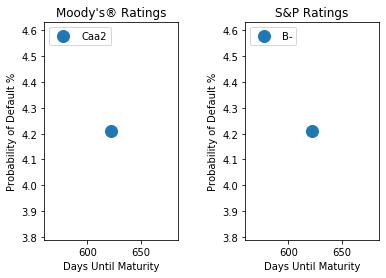

In [37]:
prob_default_term_structure(bond_df_result)

### 2. Probability of Default using Transition Matrices

Credit ratings are used in the wholesale market for bonds issued by corporations and government entities as well as for asset-backed securities (ABS). The three major global credit rating agencies are Moody’s Investors Service, Standard & Poor’s, and Fitch Ratings. Each provides quality ratings for issuers as well as specific issues. These are ordinal ratings focusing on the probability of default.

The credit rating agencies consider the expected loss given default by means of notching, which is an adjustment to the issuer rating to reflect the priority of claim for specific debt issues of that issuer and to reflect any subordination. The issuer rating is typically for senior unsecured debt. The rating on subordinated debt is then adjusted, or “notched,” by lowering it one or two levels—for instance, from A+ down to A or further down to A–. This inclusion of loss given default in addition to the probability of default explains why they are called “credit ratings” and not just “default ratings.”

The rating agencies report transition matrices based on their historical data. We can verify the accuracy of the market-implied default probabilities with these rating agencies' transition matrices. Using the code below, we can obtain the Standard & Poor’s Average One-Year Transition Rates For Global Corporates using historical data from 1981-2019 to verify the market-implied default probabilities calculated earlier.

In [23]:
tgt_website = r'https://www.spglobal.com/ratings/en/research/articles/200429-default-transition-and-recovery-2019-annual-global-corporate-default-and-rating-transition-study-11444862'

In [24]:
def get_transition_matrix(tgt_website):
 
    df_list = pd.read_html(tgt_website)
    matrix_result_df = df_list[22]
    
    return matrix_result_df
 
transition_matrix_df = get_transition_matrix(tgt_website)

In [25]:
sp_clean_result_df = pd.DataFrame(transition_matrix_df.iloc[:34,:19].dropna(axis=0))
sp_clean_result_df

Average One-Year Transition Rates For Global Corporates By Rating Modifier (1981-2019) (%)  \
                                                                                      From/to   
0                                                 AAA                                           
2                                                 AA+                                           
4                                                  AA                                           
6                                                 AA-                                           
8                                                  A+                                           
10                                                  A                                           
12                                                 A-                                           
14                                               BBB+                                           
16                                                BBB                                           
18                                               BBB-                                           
20                                                BB+                                           
22                                                 BB                                           
24                                                BB-                                           
26                                                 B+                                           
28                                                  B                                           
30                                                 B-                                           
32                                              CCC/C                                           

                                                                          \
      AAA    AA+     AA    AA-     A+      A     A-   BBB+    BBB   BBB-   
0   87.03   5.89   2.51   0.69   0.16   0.24   0.13   0.00   0.05   0.00   
2    2.31  78.94  10.91   3.54   0.71   0.33   0.19   0.05   0.09   0.05   
4    0.42   1.31  80.76   8.53   2.72   1.15   0.36   0.39   0.13   0.08   
6    0.04   0.11   3.77  78.80   9.68   2.19   0.60   0.25   0.15   0.07   
8    0.00   0.06   0.44   4.44  78.38   8.73   2.15   0.61   0.34   0.09   
10   0.03   0.04   0.22   0.41   5.32  78.88   6.74   2.38   0.86   0.27   
12   0.04   0.01   0.06   0.15   0.42   6.49  78.12   7.23   1.98   0.57   
14   0.00   0.01   0.05   0.06   0.20   0.74   7.13  75.83   7.98   1.56   
16   0.01   0.01   0.04   0.03   0.10   0.31   1.00   7.73  76.00   6.11   
18   0.01   0.01   0.02   0.04   0.06   0.14   0.25   1.17   9.31  72.40   
20   0.04   0.00   0.00   0.03   0.03   0.08   0.08   0.41   1.59  11.33   
22   0.00   0.00   0.03   0.01   0.00   0.06   0.05   0.16   0.47   2.00   
24   0.00   0.00   0.00   0.01   0.01   0.01   0.05   0.09   0.23   0.35   
26   0.00   0.01   0.00   0.03   0.00   0.03   0.06   0.04   0.05   0.10   
28   0.00   0.00   0.01   0.01   0.00   0.03   0.04   0.02   0.05   0.03   
30   0.00   0.00   0.00   0.00   0.02   0.03   0.00   0.06   0.05   0.10   
32   0.00   0.00   0.00   0.00   0.03   0.00   0.08   0.05   0.08   0.05   

                                                            
      BB+     BB    BB-     B+      B     B-    CCC      D  
0    0.03   0.05   0.03   0.00   0.03   0.00   0.05   0.00  
2    0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00  
4    0.05   0.03   0.02   0.02   0.00   0.02   0.05   0.02  
6    0.03   0.00   0.00   0.03   0.08   0.00   0.00   0.03  
8    0.06   0.09   0.01   0.07   0.03   0.00   0.00   0.05  
10   0.10   0.10   0.06   0.08   0.02   0.00   0.01   0.05  
12   0.13   0.13   0.11   0.10   0.02   0.01   0.03   0.06  
14   0.36   0.29   0.13   0.15   0.10   0.02   0.06   0.10  
16   1.34   0.58   0.27   0.22   0.11   0.03   0.05   0.16  
18   5.47   2.08   0.83   0.36   0.22   0.1

The above is the Standard & Poor’s 2019 transition matrix. It shows the probabilities of a particular rating transitioning to another over the course of the following year. An A-rated issuer has an 78.88% probability of remaining at that level, a 0.03% probability of moving up to AAA; a 0.22% probability of moving up to AA; an 0.86% probability of moving down to BBB; 0.10% down to BB; 0.02% to B, 0.01% to CCC, CC, or C; and 0.05% to D, where it is in default.

Using the Selenium script earlier to retrieve the Standard & Poor’s credit ratings, we can use the corporate bond's credit rating to determine the probability of a particular rating transitioning to D (default) during the next year according to the Standard & Poor’s 2019 transition matrix.

In [26]:
# Will scrape the default probability for each rating

sp_rating_list = ['AAA','AA+','AA','AA-','A+','A','A-',
                  'BBB+','BBB','BBB-','BB+','BB','BB-',
                  'B+','B','B-']

ccc_list = ['CCC+','CCC','CCC-','CC+','CC','CC-','C+','C','C-']

sp_rating = None

for i in sp_rating_list:
    if bond_df_result['S&P'].iloc[0] == i:
        sp_rating = bond_df_result['S&P'].iloc[0]

if sp_rating == None:
    for i in ccc_list:
        if bond_df_result['S&P'].iloc[0] == i:
            sp_rating = 'CCC/C'

sp_transition_dp = 0

for i in range(33):
    if transition_matrix_df.loc[i][0] == sp_rating:
        sp_transition_dp += float(sp_clean_result_df.loc[i][18])

sp_transition_dp

6.49

It appears that the market-implied probability of default we calculated for the nearest maturity corporate bond is close to the probability of default as determined from the historical data in the Standard & Poor’s 2019 transition matrix.

In [38]:
# Compare the nearest maturity Market-implied probability of default with
# the historical probability of default in the Standard & Poor’s 2019 transition matrix
print("Market-implied probability of default = %s"%(bond_df_result['Probability of Default %'].iloc[0])+"%")
print("Standard & Poor’s probability of default = %s"%(sp_transition_dp)+"%")

Market-implied probability of default = 4.21%
Standard & Poor’s probability of default = 6.49%


### 3. Conclusion

In the example above, the bond valuation techniques using a Risk-adjusted Discount Rate does a reasonably good job at estimating the market-implied default probabilities. We calculated the Expected Cash Flow at each period by adding the product of the Default Payout and the Probability of Default (P) with the product of the promised payment (Coupon Payments and repayment of Principal) and the probability of not defaulting (1-P). One reason for any differences between historical and market-implied default probabilities is that historical default probabilities do not include the default risk premium associated with uncertainty over the timing of possible default loss.

The model used here is very sensitive to the discount and Recovery Rates selected. We assume a flat government bond yield curve, but it could be upward or downward sloping. If the government bond yield curve was sloped, the discount rates would need to be calculated sequentially by a process known as “bootstrapping.” We also assume in this example that the Recovery Rate is 40%, but another possibility is to change the assumed Recovery Rate to either 30% or 60% of exposure. Another simplifying assumption is that recovery is instantaneous. In practice, lengthy time delays can occur between the event of default and eventual recovery of cash. Notice that we assume that the Recovery Rate applies to interest as well as principal.

Also, we assume that default occurs only on coupon payment dates and that default will not occur on date 0, the current date. Although we assumed the annual default probability is the same each year, this does not need to be the case.

Even with the assumptions made in this analysis, the market-implied probability of default model built here does a fairly good job at identifying risk of corporate defaults and may suffice for simply rank ordering firms by credit worthiness.

### 4. Additional Reading and Code

*Bayesian Pairs Trading using Corporate Supply Chain Data*<br>
If you liked this article, you may enjoy AlphaWave Data's [Bayesian Pairs Trading using Corporate Supply Chain Data](https://medium.com/@hdonnelly6/bayesian-pairs-trading-using-corporate-supply-chain-data-8b96305686d) article.  Using the [AlphaWave Data Corporate Supply Chain API](https://rapidapi.com/alphawave/api/corporate-supply-chain/endpoints), we can get a list of suppliers and customers for a given stock symbol.  You can further filter this list of suppliers and customers using the two-stage FCFF valuation model discussed in [Stock Valuation Using Free Cash Flow to the Firm With Python](https://hdonnelly6.medium.com/stock-valuation-using-free-cash-flow-to-the-firm-with-python-9a2f0e8f308f) to get a grouping of good pairs trading candidates that are potentially misvalued.  A list of company tickers that have supply chain data is included at the bottom of the Jupyter Notebooks available on [Google Colab](https://colab.research.google.com/drive/1e_SiiZn7WEW3OUNG-ftN3riPNjiz0M0C?usp=sharing) and [Github](https://github.com/AlphaWaveData/Jupyter-Notebooks/blob/master/AlphaWave%20Corporate%20Supply%20Chain%20API%20Example.ipynb), which could be a good list of tickers to run through the two-stage FCFF valuation model discussed further below.

*Stock Valuation Using Free Cash Flow to the Firm With Python*<br>
You may also like [Stock Valuation Using Free Cash Flow to the Firm With Python](https://hdonnelly6.medium.com/stock-valuation-using-free-cash-flow-to-the-firm-with-python-9a2f0e8f308f) where we discuss how to value stocks using a two-stage Free Cash Flow to the Firm model using the [AlphaWave Data Financial Statements API](https://rapidapi.com/alphawave/api/financial-statements/endpoints) and the [AlphaWave Data Stock Analysis API](https://rapidapi.com/alphawave/api/stock-analysis/endpoints).  Jupyter Notebooks detailing this analysis are also available on [Google Colab](https://colab.research.google.com/drive/1BWmRIDtZGRndLk8lLGgpoURaAzHC8_jg?usp=sharing) and [Github](https://github.com/AlphaWaveData/Jupyter-Notebooks/blob/master/AlphaWave%20Stock%20Valuation%20using%20Free%20Cash%20Flow%20to%20the%20Firm%20example.ipynb).